# Likelihood-based models

This notebook will outline the likelihood-based approach to training on Bandit feedback.

Although before proceeding, we will study the output of the simulator in a little more detail.

In [2]:
import math
import numpy as np
from numpy.random.mtrand import RandomState
from recogym import Configuration
from recogym.agents import Agent
from sklearn.linear_model import LogisticRegression

from recogym.agents import OrganicUserEventCounterAgent, organic_user_count_args
from recogym.agents import BanditCount, bandit_count_args, OrganicCount, organic_count_args
from recogym.agents import OrganicMFSquare, organic_mf_square_args, BanditMFSquare, bandit_mf_square_args
from recogym.agents import RandomAgent, random_args
from recogym.agents import FeatureProvider
from recogym import Configuration, DefaultContext, Observation
from recogym.envs.session import OrganicSessions
from recogym.evaluate_agent_sale import verify_agents_sale, plot_verify_agents_sale
from recogym.envs.utils_sale import *

import gym, recogym
from copy import deepcopy
from recogym import env_1_sale_args
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [6, 3]

num_users = 1000

env_1_sale_args['sigma_mu_organic'] = 0
env_1_sale_args['sigma_omega'] = 1
env_1_sale_args['random_seed'] = 42
env_1_sale_args['K'] = 5
env_1_sale_args['number_of_flips'] = 5
env = gym.make('reco-gym-sale-v1')
env.init_gym(env_1_sale_args)

num_products = env_1_sale_args['num_products']

In [3]:
data = deepcopy(env).generate_logs(num_users)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00:00, 28.33it/s]


## Likelihood agent

In [4]:
from recogym.envs.utils_sale import CountFeatureProvider, build_train_data, LikelihoodAgent

In [6]:
# You can now see data that will be provided to our agents based on logistic regressions.
config = Configuration(env_1_sale_args)
count_feature_provider = CountFeatureProvider(config=config)

user_states, actions, rewards, proba_actions = build_train_data(data, count_feature_provider)

In [13]:
%%time

count_product_views_feature_provider = CountFeatureProvider(config)

# likelihood agent
likelihood_logreg = LikelihoodAgent(count_product_views_feature_provider)
likelihood_logreg.train(data)

Estimated sales rate :  [0.01504996 0.01988274 0.01967958 0.0194912  0.01978077 0.01891458
 0.01965066 0.01816347 0.01946223 0.02094241]
Wall time: 38.5 s


## Baselines

In [9]:
from recogym.envs.utils_sale import SingleActionAgent

# Initialise baselines
random_agent = RandomAgent(Configuration(random_args))
sales = [data["r"][data['a']==a].sum() for a in range(num_products)]
_, views = np.unique(data[data['z'] == 'organic']['v'], return_counts=True)
greedy_bandit = SingleActionAgent(np.argmax(sales), Configuration(env_1_sale_args))
greedy_organic = SingleActionAgent(np.argmax(views), Configuration(env_1_sale_args))
count_organic = OrganicCount()
count_bandit = BanditCount()

In [10]:
result_baselines = verify_agents_sale(
    env,
    number_of_users=2000,
    agents={
        'random agent': random_agent,
        'greedy_organic':greedy_organic,
        'greedy_bandit':greedy_bandit,
        'count_organic':count_organic,
        'count_bandit':count_bandit
    }
)

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:13<00:00, 27.16it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:09<00:00, 28.62it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:05<00:00, 30.66it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:08<00:00, 29.00it/s]
Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:10<00:00, 28.36it/s]


## Likelihood, user organic count, bandit & organic MF

In [11]:
# organic user-specific counter agent
organic_user_counter_agent = OrganicUserEventCounterAgent(
    Configuration({
        **organic_user_count_args,
        **env_1_sale_args,
        'select_randomly': True,
    })
)

# Organic and bandit MF
organic_mf = OrganicMFSquare()
bandit_mf = BanditMFSquare()

In [ ]:
result = verify_agents_sale(
    env,
    number_of_users=2000,
    agents={
        'Organic User Count': organic_user_counter_agent,
        'Likelihood LogReg': likelihood_logreg,
        'Organic MF' : organic_mf,
        'Bandit MF' : bandit_mf
    }
)

## Contextual bandit : vanilla, log & POEM

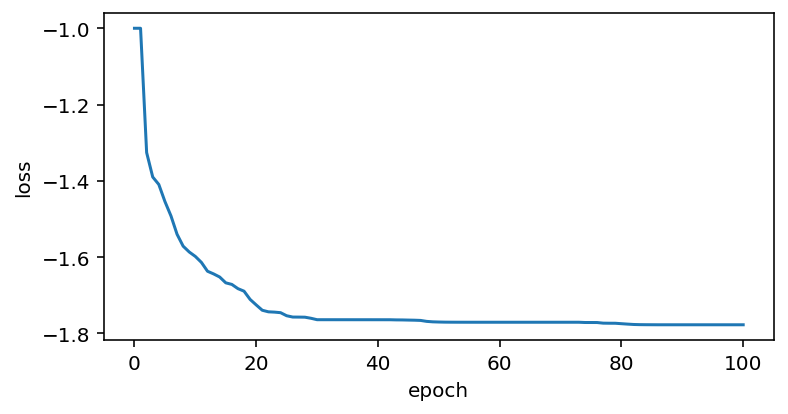

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:39<00:00, 20.07it/s]


In [38]:
from recogym.envs.utils_sale import ProductCountFeatureProvider, VanillaContextualBandit, MultinomialLogisticRegressionModel,build_rectangular_data
from recogym.envs.utils_sale import LogContextualBandit, PoemContextualBandit

rectangular_logs = build_rectangular_data(data, count_product_views_feature_provider)

vanilla_cb = VanillaContextualBandit({}, max_epoch=100)
vanilla_cb.train(rectangular_logs)
vanilla_cb.plot_loss_history()
result_AB_vanillaCB = verify_agents_sale(env, 2000, {'Contextual Bandit': vanilla_cb})


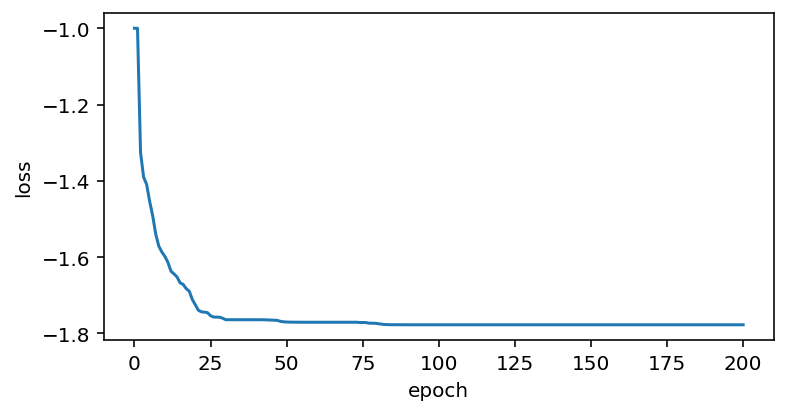

Organic Users: 0it [00:00, ?it/s]
Users: 100%|███████████████████████████████████████████████████████████████████████| 2000/2000 [01:40<00:00, 19.96it/s]


In [39]:
log_cb = LogContextualBandit({}, max_epoch=200)
log_cb.train(rectangular_logs)
log_cb.plot_loss_history()
result_AB_LogCB = verify_agents_sale(env, 2000, {'Log Contextual Bandit': log_cb})

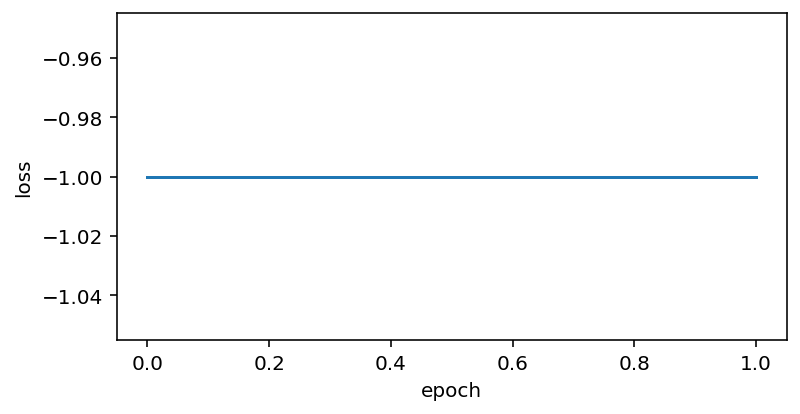

In [50]:
poem = PoemContextualBandit({}, variance_penalization_factor=0.4, max_epoch=100)
poem.train(rectangular_logs)
poem.plot_loss_history()
result_AB_POEM = verify_agents_sale(env, 2000, {f'POEM': poem})

## Compare results

In [42]:
result_concat = (pd.concat([result_baselines[0],result[0],result_AB_vanillaCB[0],result_AB_LogCB[0],result_AB_POEM[0]]),
                pd.concat([result_baselines[1],result[1],result_AB_vanillaCB[1],result_AB_LogCB[1],result_AB_POEM[1]]))

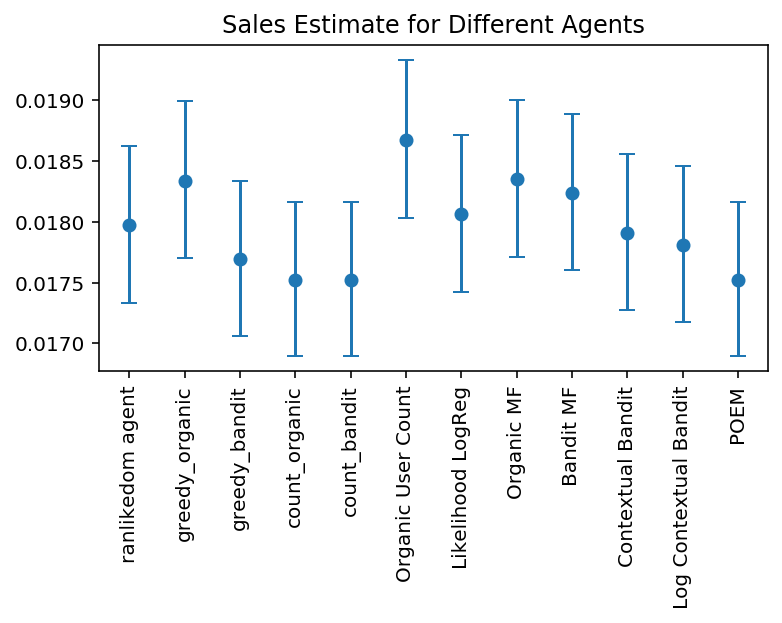

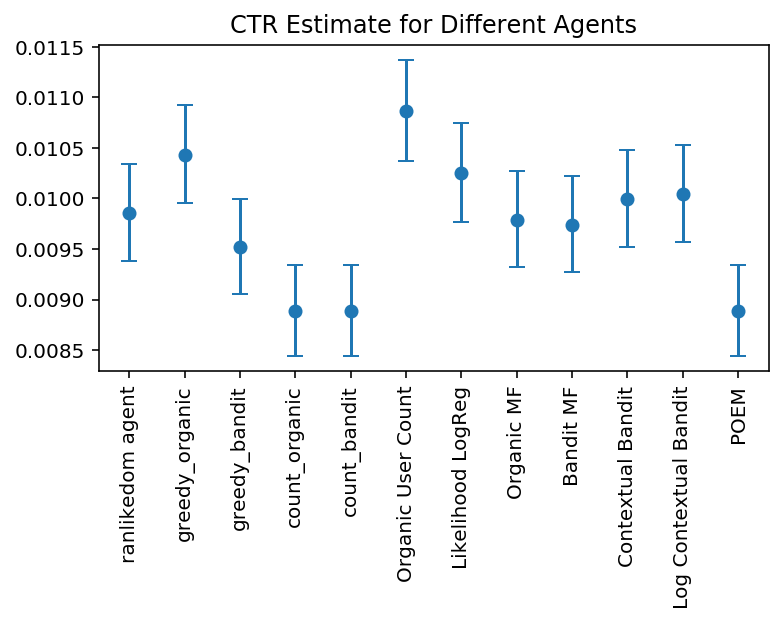

In [43]:
fig = plot_verify_agents_sale(*result_concat)
plt.show()